# Segmentation des communes françaises

Objectif : regrouper les communes présentant des profils
socio-économiques similaires afin d’adapter les politiques
publiques et les priorités d’investissement.


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

CLEAN_PATH = "/content/drive/MyDrive/Projet Data/projet_1_diagnostic_territorial/data/clean/"

In [3]:
df = pd.read_csv(CLEAN_PATH + "df_analyse.csv")

df.head()

,dep,codgeo,libgeo,population,revenu_median,categorie_revenu,pression_socioeco
0,85,85062,Châteauneuf,1134.0,22110.0,Faible,0.135085
1,58,58300,Urzy,1742.0,24410.0,Moyen,0.193148
2,70,70137,Chassey-lès-Montbozon,225.0,22710.0,Faible,0.026319
3,51,51649,Vitry-le-François,11454.0,17890.0,Très faible,1.537702
4,78,78638,Vaux-sur-Seine,5083.0,29160.0,Élevé,0.477038


In [4]:
#S élection des variables pour le clustering
features = df[[
    "population",
    "revenu_median",
    "pression_socioeco"
]].dropna()


On choisit peu de variables, mais pertinentes.
On exclut les communes sans revenu pour éviter le bruit.

In [5]:
#Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

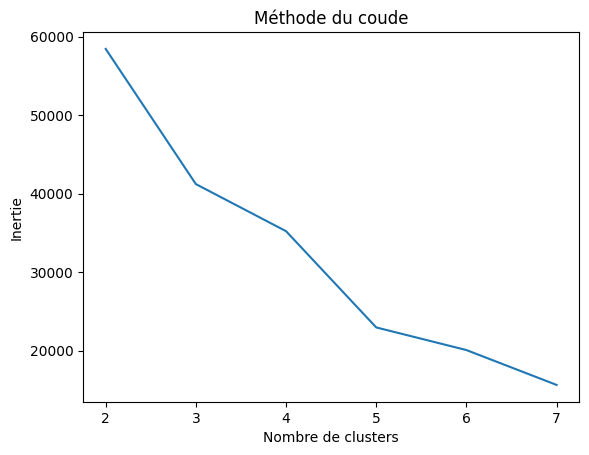

In [6]:
inertia = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 8), inertia)
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.show()


## Choix du nombre de clusters

La méthode du coude met en évidence une forte diminution de l’inertie entre 2 et 4 clusters,
puis un ralentissement significatif de la baisse à partir de 5 clusters.

Le point d’inflexion observé autour de **4 clusters** indique un bon compromis entre :
- la qualité de la segmentation,
- la simplicité du modèle,
- et l’interprétabilité des résultats.

En conséquence, le nombre de clusters retenu pour la segmentation des communes est **k = 4**,
afin de produire des groupes lisibles et exploitables pour l’aide à la décision publique.


In [7]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

features["cluster"] = clusters

In [8]:
#On ramène les clusters au dataset original.
df_clustered = df.loc[features.index].copy()
df_clustered["cluster"] = clusters

df_clustered.groupby("cluster")[[
    "population",
    "revenu_median",
    "pression_socioeco"
]].mean()


,population,revenu_median,pression_socioeco
cluster,,,
0,1747.481474,21001.455083,0.216643
1,132617.788235,22438.588235,15.498974
2,3350.913183,30910.601746,0.290869
3,1451.456774,24630.211656,0.159002


## Interprétation des clusters

- Cluster 0 : communes peu peuplées, revenus faibles
- Cluster 1 : communes très peuplées, pression socio-économique élevée
- Cluster 2 : communes favorisées
- Cluster 3 : communes intermédiaires

Ces segments permettent d’adapter les politiques publiques
selon les profils territoriaux.


In [9]:
#Sauvegarde de la dataset
df_clustered.to_csv(
    CLEAN_PATH + "df_clustered.csv",
    index=False
)
